In [1]:
import numpy,pandas,copy
acc_train=pandas.read_csv('Pylon/accepted_train.csv',header=[0,1,2,3],index_col=0)
exc_train=pandas.read_csv('Pylon/excluded_train.csv',header=[0,1,2,3],index_col=0)
acc_test=pandas.read_csv('Pylon/accepted_test.csv',header=[0,1,2,3],index_col=0)
exc_test=pandas.read_csv('Pylon/excluded_test.csv',header=[0,1,2,3],index_col=0)
print([i.shape for i in [acc_train,exc_train,acc_test,exc_test]])

[(13718, 8), (586282, 8), (6632, 8), (293368, 8)]


In [2]:
# data_array=numpy.vstack((acc_array,exc_train.values))
data_array=numpy.vstack((acc_train.values,exc_train.values[:13718]))
test_array=numpy.vstack((acc_test.values,exc_test.values[:6632]))

In [3]:
#print(data.shape)

In [4]:
lenth=data_array.shape[0];lenth

27436

In [5]:
#normalize=numpy.linalg.inv(numpy.diag([60,1e3,2e3,6e3,2e3,2e3,2e3,1,1,3e3,3e3,1500]))
import sys,pandas
sys.path.append('/home/heyangle/Desktop/ScanCraft/ScanCraft')
from command.scan.scan import scan

mold=scan(method='random')
mold.AddScalar('tanB','MINPAR',3,1.,60.)
mold.AddScalar('Atop','EXTPAR'   ,11  ,  -6e3    ,6e3)
mold.AddFollower('Abottom','EXTPAR'   ,12,'Atop')
mold.AddScalar('Lambda','EXTPAR'  ,61  ,1e-3    ,1. ,prior_distribution='exponential')
mold.AddScalar('Kappa','EXTPAR'   ,62 ,1.e-3    ,1. ,prior_distribution='exponential')
mold.AddScalar('A_Lambda','EXTPAR' ,63,-3.e3,3.e3)
mold.AddScalar('A_kappa','EXTPAR' ,64,-3.e3,3.e3)
mold.AddScalar('mu_eff','EXTPAR'  ,65,100.,1500.)

In [6]:
mold.free_parameter_list.keys()

dict_keys(['tanB', 'Atop', 'Lambda', 'Kappa', 'A_Lambda', 'A_kappa', 'mu_eff'])

In [7]:
from command.pytorch.normalize import GetRanges
data_range=GetRanges(mold.free_parameter_list)
data_range

array([[  1.00000000e+00,  -6.00000000e+03,   1.00000000e-03,
          1.00000000e-03,  -3.00000000e+03,  -3.00000000e+03,
          1.00000000e+02],
       [  6.00000000e+01,   6.00000000e+03,   1.00000000e+00,
          1.00000000e+00,   3.00000000e+03,   3.00000000e+03,
          1.50000000e+03]])

In [8]:
#data_range

In [9]:
inp_middle=data_array[:,:7]-(data_range[0]+data_range[1])/2
inp_norm=inp_middle/(data_range[1]-data_range[0])*2
test_norm=(test_array[:,:7]-(data_range[0]+data_range[1])/2)/(data_range[1]-data_range[0])*2

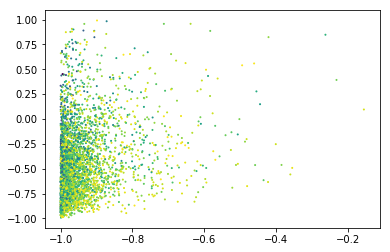

In [10]:
import matplotlib.pyplot as plt
plt.scatter(inp_norm[:4000,2],inp_norm[:4000,3],s=1,c=inp_norm[:4000,0])
plt.show()

In [11]:
inp_full=numpy.hstack((inp_norm,inp_norm**2*2,inp_norm**3*3,inp_norm**4*4))
test_full=numpy.hstack((test_norm,test_norm**2*2,test_norm**3*3,test_norm**4*4))
print(inp_full.shape,test_full.shape)

(27436, 28) (13264, 28)


In [12]:
# import matplotlib.pyplot as plt
# plt.figure()
# plt.plot(inp_full[:,21],marker='.',linewidth=0,markersize=1)
# plt.show()

In [13]:
import torch
from torch.autograd import Variable
from torch import nn
bce=nn.BCEWithLogitsLoss()#size_average=False)
in_data=Variable(torch.FloatTensor(inp_full).cuda())
target=Variable(torch.FloatTensor(data_array[:,-1].reshape(lenth,1)).cuda(), requires_grad=False)
test=Variable(torch.FloatTensor(test_full).cuda())
test_target=Variable(torch.FloatTensor(test_array[:,-1].reshape(len(test_array),1)).cuda(), requires_grad=False)

In [14]:
sum(target)

Variable containing:
 13718
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [15]:
# W1=Variable(torch.FloatTensor(numpy.random.uniform(size=(7,1000))).cuda())
# W2=Variable(torch.FloatTensor(numpy.random.uniform(size=(1000,1))).cuda())
# global W1,W2

In [16]:
class model(nn.Module):
    def __init__(self,D_in,d1,d2):
        super(model,self).__init__()
        self.l1=torch.nn.Linear(D_in, d1)
        self.l2=torch.nn.Linear(d1,d2)
        self.l3=torch.nn.Linear(d2,1)
    def forward(self,x):
        x=self.l1(x)
        x=nn.functional.relu(x)
        x=torch.sqrt(x)
        x=self.l2(x)
        x=nn.functional.leaky_relu(x)
        x=self.l3(x)
        x=torch.nn.functional.sigmoid(x)
        return x

In [17]:
PM=model(28,1000,500).cuda()

In [18]:
optimizer=torch.optim.Adagrad(PM.parameters())

In [19]:
for i in range(100):
    yp=PM(in_data)
    loss=bce(yp,target)
    if i%100==0:
        print(i,loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(loss)

0 0.7233521938323975
Variable containing:
 0.5191
[torch.cuda.FloatTensor of size 1 (GPU 0)]



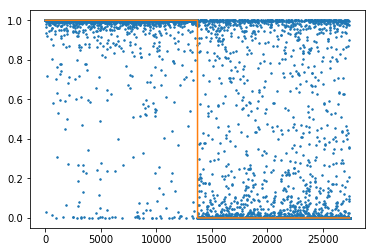

Variable containing:
 0.5191
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [20]:
import matplotlib.pyplot as plt
plt.plot(PM(in_data).cpu().data.numpy().reshape(lenth,),marker='.',markersize=3,linewidth=0)
plt.plot(data_array[:,-1])
plt.show()
print(loss)

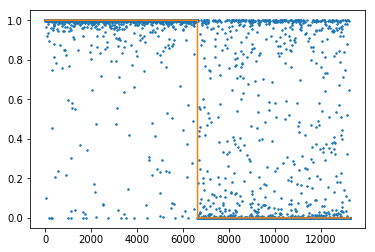

Variable containing:
 0.5230
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [21]:
plt.plot(PM(test).cpu().data.numpy().reshape(len(test_array),),marker='.',markersize=3,linewidth=0)
plt.plot(test_array[:,-1])
plt.show()
print(bce(PM(test),test_target))

In [23]:
torch.save(PM,'calculable')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [17]:
import torch
PM2=torch.load('classify')

In [18]:
PM2(inp_full)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [71]:
test

Variable containing:

Columns 0 to 5 
 5.5730e+01  4.3812e+03  1.0891e-03  3.5555e-01 -1.4570e+03 -2.4354e+03
 5.3807e+01 -3.7114e+03  9.4566e-03  8.0453e-02  2.3274e+03 -1.4201e+03
 5.9181e+01 -4.0570e+02  1.4997e-02  5.3161e-02  2.8559e+03 -1.1110e+03
 3.5358e+01 -1.8828e+03  8.1498e-02  4.6878e-01 -2.7743e+03 -3.9452e+02
 3.5608e+01 -1.6186e+03  5.8424e-03  7.0648e-01  1.0715e+03 -1.5334e+03
 3.6243e+01 -1.9003e+03  8.5638e-02  3.1542e-01  2.9482e+03 -2.1079e+03
 5.2304e+01 -5.1961e+02  7.4161e-02  2.7289e-01  2.2573e+03 -2.6618e+03

Columns 6 to 7 
 1.3675e+03  1.0000e+00
 1.4928e+03  1.0000e+00
 1.0124e+03  1.0000e+00
 1.3783e+03  1.0000e+00
 4.7073e+02  1.0000e+00
 1.0775e+03  1.0000e+00
 8.3434e+02  1.0000e+00
[torch.cuda.FloatTensor of size 7x8 (GPU 0)]

In [13]:
# model=torch.nn.Sequential(
#     torch.nn.Linear(12,1000),
#     torch.nn.Linear(1000,1000),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(1000,100),
#     nn.ELU(),
#     nn.Linear(100,1),
#     torch.nn.Sigmoid()
# ).cuda()

In [15]:
    for param in model.parameters():
        nn.init.uniform(param,a=-0.5,b=0.5)

In [ ]:
for i in range(100000):
    model.zero_grad()
    loss=bce(model(in_data),target)
    if i%1000==0:
        print(i,loss.data[0])
    loss.backward()
    for param in model.parameters():
        param.data-=0.1*param.grad.data

0 0.6968688368797302


In [35]:
min_model=copy.deepcopy(model)
min_loss=1e10

In [25]:
for loop in range(10000):
    last_loss=1e10
    
    for param in model.parameters():
        nn.init.uniform(param,a=-5,b=5)
        
    for i in range(100000):
        model.zero_grad()
        loss=bce(model(in_data),target)
        if i%1000==0:
            if last_loss==loss.data[0]:
                print(loop,last_loss,'loss stop')
                break
            else:
                last_loss=loss.data[0]
                print('\t\t',i,loss.data[0])
        loss.backward()
        for param in model.parameters():
            param.data-=1.*param.grad.data
    else:
        print(loop,last_loss,'max loop')
        
    if min_loss>loss.data[0]:
        min_model=copy.deepcopy(model)
        min_loss=loss.data[0]
        print('minimal loss is %f at loop %i'%(min_loss,loop))

		 0 0.818228006362915
		 1000 0.6144364476203918
		 2000 0.5815367102622986
		 3000 0.5703349709510803
		 4000 0.564660370349884
		 5000 0.5610747337341309
		 6000 0.5590046048164368
		 7000 0.5565654039382935
		 8000 0.5553975105285645
		 9000 0.5551968812942505
		 10000 0.5523973703384399
		 11000 0.5569222569465637
		 12000 0.5506415367126465
		 13000 0.5525065064430237
		 14000 0.548419713973999
		 15000 0.55150306224823
		 16000 0.5486944913864136
		 17000 0.5507251024246216
		 18000 0.5465817451477051
		 19000 0.5446569323539734
		 20000 0.5461686849594116
		 21000 0.5471798181533813
		 22000 0.5431815385818481
		 23000 0.5426599383354187
		 24000 0.5479438900947571
		 25000 0.5412164926528931
		 26000 0.5468796491622925
		 27000 0.5402284264564514
		 28000 0.5400283932685852
		 29000 0.5398401021957397
		 30000 0.5442014336585999
		 31000 0.5386539101600647
		 32000 0.5383731126785278
		 33000 0.5400765538215637
		 34000 0.5496662259101868
		 35000 0.5370954871177673
		 36000 0

		 86000 0.5261560678482056
		 87000 0.525816023349762
		 88000 0.5273393988609314
		 89000 0.5257402658462524
		 90000 0.5274970531463623
		 91000 0.526303768157959
		 92000 0.52582186460495
		 93000 0.527457594871521
		 94000 0.5312869548797607
		 95000 0.524878203868866
		 96000 0.5299180150032043
		 97000 0.5276960730552673
		 98000 0.5258236527442932
		 99000 0.5247041583061218
4 0.5247041583061218 max loop
		 0 0.6946565508842468
		 1000 0.587360143661499
		 2000 0.5738741159439087
		 3000 0.5661629438400269
		 4000 0.5637742877006531
		 5000 0.5610994100570679
		 6000 0.559405505657196
		 7000 0.5573299527168274
		 8000 0.556930661201477
		 9000 0.5551612377166748
		 10000 0.5550225973129272
		 11000 0.5546074509620667
		 12000 0.5518813729286194
		 13000 0.5521295666694641
		 14000 0.5505596399307251
		 15000 0.5495632886886597
		 16000 0.5506494045257568
		 17000 0.550704836845398
		 18000 0.5482341647148132
		 19000 0.547802746295929
		 20000 0.546554446220398
		 21000 0.5462

		 77000 0.5295664072036743
		 78000 0.5280003547668457
		 79000 0.5288881063461304
		 80000 0.5290228128433228
		 81000 0.5357977151870728
		 82000 0.5280007719993591
		 83000 0.5280834436416626
		 84000 0.5277227759361267
		 85000 0.5274316668510437
		 86000 0.5271580219268799
		 87000 0.5272741913795471
		 88000 0.5284885168075562
		 89000 0.5268297791481018
		 90000 0.5291246175765991
		 91000 0.5283872485160828
		 92000 0.5267465114593506
		 93000 0.5273483991622925
		 94000 0.5263707637786865
		 95000 0.5265811085700989
		 96000 0.5304086208343506
		 97000 0.5313341021537781
		 98000 0.5261863470077515
7 0.5261863470077515 loss stop
		 0 0.8412752747535706
		 1000 0.6029308438301086
		 2000 0.5787605047225952
		 3000 0.5679107308387756
		 4000 0.5637266635894775
		 5000 0.562633752822876
		 6000 0.5612581372261047
		 7000 0.5563880205154419
		 8000 0.5548993349075317
		 9000 0.5530555844306946
		 10000 0.5517606735229492
		 11000 0.5509562492370605
		 12000 0.5498661398887634
		 

		 76000 0.5286877751350403
		 77000 0.5276541113853455
		 78000 0.5275046825408936
		 79000 0.537178099155426
		 80000 0.5273597240447998
		 81000 0.5272653698921204
		 82000 0.5306123495101929
		 83000 0.5362133383750916
		 84000 0.5274547338485718
		 85000 0.5271520614624023
		 86000 0.5268218517303467
		 87000 0.5267893075942993
		 88000 0.5276951789855957
		 89000 0.526423990726471
		 90000 0.5271467566490173
		 91000 0.5309960842132568
		 92000 0.5289173722267151
		 93000 0.5405943393707275
		 94000 0.5261358022689819
		 95000 0.5259726643562317
		 96000 0.52601557970047
		 97000 0.542165994644165
		 98000 0.5261215567588806
		 99000 0.5421613454818726
11 0.5421613454818726 max loop
		 0 0.8197935819625854
		 1000 0.6975994110107422
12 0.6975994110107422 loss stop
		 0 0.6926272511482239
		 1000 0.5863532423973083
		 2000 0.5719676613807678
		 3000 0.5687016248703003
		 4000 0.5641103386878967
		 5000 0.5624715685844421
		 6000 0.5590090751647949
		 7000 0.5580072999000549
		 800

		 75000 0.5278406739234924
		 76000 0.5310057997703552
		 77000 0.5279854536056519
		 78000 0.5398495197296143
		 79000 0.5272298455238342
		 80000 0.5303032398223877
		 81000 0.5271009206771851
		 82000 0.5299611687660217
		 83000 0.5267758965492249
		 84000 0.5307695269584656
		 85000 0.5271044969558716
		 86000 0.5268378257751465
		 87000 0.5262050032615662
		 88000 0.529007077217102
		 89000 0.5369625091552734
		 90000 0.5268232822418213
		 91000 0.5259261727333069
		 92000 0.5283507704734802
		 93000 0.525754988193512
15 0.525754988193512 loss stop
		 0 0.6972007155418396
		 1000 0.6940435767173767
16 0.6940435767173767 loss stop
		 0 0.7337286472320557
		 1000 0.6947526931762695
17 0.6947526931762695 loss stop
		 0 0.8038132190704346
		 1000 0.5792346000671387
		 2000 0.5682069063186646
		 3000 0.5618814826011658
		 4000 0.5591005682945251
		 5000 0.556738555431366
		 6000 0.5578146576881409
		 7000 0.5541324615478516
		 8000 0.5521330237388611
		 9000 0.5517870187759399
		 1000

		 64000 0.533387303352356
		 65000 0.5383381843566895
		 66000 0.5326151847839355
		 67000 0.536088764667511
		 68000 0.5318359136581421
		 69000 0.5316876173019409
		 70000 0.5341116786003113
		 71000 0.534515380859375
		 72000 0.5330001711845398
		 73000 0.5403153896331787
		 74000 0.5435841083526611
		 75000 0.5314245223999023
		 76000 0.5309401750564575
		 77000 0.5307673215866089
		 78000 0.5309986472129822
		 79000 0.5305396914482117
		 80000 0.5425602197647095
		 81000 0.5312277674674988
		 82000 0.5301534533500671
21 0.5301534533500671 loss stop
		 0 0.7136391401290894
		 1000 0.6958035230636597
22 0.6958035230636597 loss stop
		 0 0.8445635437965393
		 1000 0.6140414476394653
		 2000 0.5773346424102783
		 3000 0.5692507028579712
		 4000 0.5626773834228516
		 5000 0.5608735680580139
		 6000 0.5590590238571167
		 7000 0.5558152198791504
		 8000 0.556148886680603
		 9000 0.5530716180801392
		 10000 0.5526763200759888
		 11000 0.5513231754302979
		 12000 0.5496873259544373
		 130

		 68000 0.531734049320221
		 69000 0.5404012799263
		 70000 0.5430759787559509
		 71000 0.5291179418563843
		 72000 0.5356671810150146
		 73000 0.5288593173027039
		 74000 0.5290448069572449
		 75000 0.5352836847305298
		 76000 0.5285156965255737
		 77000 0.5274428725242615
		 78000 0.5291978716850281
		 79000 0.5389035940170288
		 80000 0.5274081230163574
		 81000 0.53096604347229
		 82000 0.5384312272071838
		 83000 0.5301875472068787
		 84000 0.5278338193893433
		 85000 0.5286788940429688
		 86000 0.5264914631843567
		 87000 0.540893018245697
		 88000 0.5262699127197266
		 89000 0.5262458324432373
		 90000 0.5261632800102234
		 91000 0.5262228846549988
		 92000 0.5258798599243164
		 93000 0.5281140804290771
		 94000 0.5286464095115662
		 95000 0.5257993936538696
		 96000 0.5281255841255188
		 97000 0.5255821347236633
		 98000 0.5275086760520935
		 99000 0.5260021090507507
26 0.5260021090507507 max loop
		 0 0.7872744202613831
		 1000 0.5777783989906311
		 2000 0.5679776072502136
		

KeyboardInterrupt: 

In [26]:
min_loss

0.5240358114242554

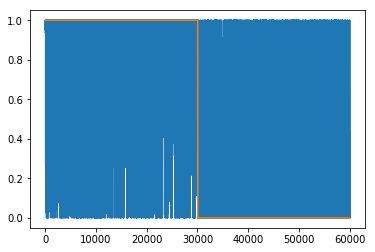

Variable containing:
 0.5515
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [42]:
import matplotlib.pyplot as plt
plt.plot(min_model(in_data).cpu().data.numpy().reshape(lenth,))
plt.plot(data[:,-1])
plt.show()
print(loss)

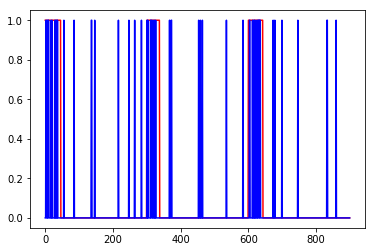

55.0000000142


In [37]:
check_in=Variable(torch.FloatTensor(test[:,:-1]).cuda())
# check_out=Variable(torch.FloatTensor(test[:,-1].reshape(300,1)).cuda())
check_out=model(check_in).cpu().data.numpy().reshape(900,)
plt.plot(test[:,12],c='r')
plt.plot(check_out,c='b')
plt.show()
print(sum(check_out))

In [34]:
for param in model.parameters():
    s=tuple(param.data.shape)
    print(s)
#     param.data=numpy.random.rand(s)
    torch.nn.init.normal(param.data, mean=1, std=5)

(1000, 12)
(1000,)
(1, 1000)
(1,)


In [27]:
for param in model.parameters():
    print(param.data)


-4.5602e+00 -8.9516e-01 -1.5086e+00  ...   3.0481e+00  1.3654e-01  5.9687e+00
 9.0939e+00  1.0026e+01  2.4713e+00  ...  -8.4557e+00 -2.0936e+00  5.0208e+00
 2.2445e+00 -9.2551e-03 -4.7440e+00  ...   3.0885e+00  2.3977e+00 -5.8149e+00
                ...                   ⋱                   ...                
-3.4574e-01  2.9277e-01  5.0781e+00  ...  -1.1510e+00  1.3061e+01  1.7336e+00
-6.1094e+00  7.0114e+00  8.3738e+00  ...  -4.6908e+00  6.2835e+00  1.0947e+00
 2.4512e+00 -3.1613e+00  2.0643e+00  ...   1.2124e+01  2.9842e+00  4.8571e+00
[torch.cuda.FloatTensor of size 1000x12 (GPU 0)]


-11.6354
  5.9850
 13.0166
   ⋮    
 -5.8924
 -2.0606
 -0.9905
[torch.cuda.FloatTensor of size 1000 (GPU 0)]


 -5.0823  -8.0376  -3.1142  ...   -8.6673   8.7855  12.4454
[torch.cuda.FloatTensor of size 1x1000 (GPU 0)]


 6.8878
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [25]:
for param in model.parameters():
    print(param.grad.data)


-8.9646e-10 -3.1003e-09 -2.2022e-09  ...   7.8005e-10 -3.5961e-09  3.8002e-09
-1.6604e-08 -5.7421e-08 -4.0788e-08  ...   1.4448e-08 -6.6604e-08  7.0385e-08
 6.5942e-08  2.2805e-07  1.6199e-07  ...  -5.7379e-08  2.6452e-07 -2.7954e-07
                ...                   ⋱                   ...                
-3.8279e-08 -1.3238e-07 -9.4034e-08  ...   3.3308e-08 -1.5355e-07  1.6227e-07
 3.4063e-08  1.1780e-07  8.3678e-08  ...  -2.9639e-08  1.3664e-07 -1.4440e-07
 8.3670e-08  2.8937e-07  2.0554e-07  ...  -7.2807e-08  3.3564e-07 -3.5470e-07
[torch.cuda.FloatTensor of size 1000x12 (GPU 0)]


1.00000e-07 *
 -0.0292
 -0.5411
  2.1491
    ⋮   
 -1.2475
  1.1101
  2.7269
[torch.cuda.FloatTensor of size 1000 (GPU 0)]


1.00000e-06 *
-0.0061  0.2468 -0.9461  ...   0.5562 -0.4848 -1.2250
[torch.cuda.FloatTensor of size 1x1000 (GPU 0)]


1.00000e-07 *
  3.1097
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [77]:
loss.data[0]

41588.83203125